dataset:

---


https://github.com/liaopeiyuan/artbench

In [ ]:
import imageio
import seaborn as sns

# Download dataset info and images

**Import helper functions**

In [ ]:
from google.colab import drive
# add flag force_remount=True if you changed or added util files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# common utils for training functions
# change the path to google drive if elsewhere.
# this copies all of the utils file from drive to separate folder
# if this does not work you can always add functions manualy

import sys
if '/content/utils' not in sys.path:
  sys.path.insert(0, '/content/utils')

!cp -r '/content/drive/My Drive/Colab Notebooks/utils' '/content'

In [ ]:
from artworks_helpers import *

In [ ]:
# helpers for markdown, this should be moved to utils
from IPython.display import display, Markdown
FINDINGS_SECTION = 'Findings'

count_markdown_section = defaultdict(int)

def add_notebook_section(section):
  count_markdown_section[section] += 1

  markdown_text = """## {section} {count_markdown} ##

  """

  return markdown_text.format(section=section, count_markdown=f"{count_markdown_section[section]:02d}")

def display_section(section):
  display(Markdown(add_notebook_section(section)))

**Download dataset**

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data('https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar')

**Genres are stored in separate folders**

In [ ]:
!ls {path}/train

art_nouveau  expressionism  post_impressionism	renaissance  surrealism
baroque      impressionism  realism		romanticism  ukiyo_e


In [ ]:
!ls {path}/test

art_nouveau  expressionism  post_impressionism	renaissance  surrealism
baroque      impressionism  realism		romanticism  ukiyo_e


In [ ]:
!ls {path}/train/art_nouveau | head -n 3

achille-beltrame_1911-attack-on-the-night-watch-1911.jpg
achille-beltrame_a-moments-rest-1937.jpg
achille-beltrame_austro-hungarian-troops-trying-to-cross-a-river-1918.jpg


**Download the information about dataset**

In [ ]:
url = "https://artbench.eecs.berkeley.edu/files/ArtBench-10.csv"
df = pd.read_csv(url)
df.columns

Index(['name', 'artist', 'url', 'is_public_domain', 'length', 'width', 'label',
       'split', 'cifar_index'],
      dtype='object')

**Store full filepath to the location of file**

In [ ]:
df['full_path'] = path/df['split']/df['label']/df['name']

In [ ]:
data = df[df['split'] == 'train']
data.head()

,name,artist,url,is_public_domain,length,width,label,split,cifar_index,full_path
0,frank-omeara_towards-night-and-winter.jpg,frank-omeara,https://uploads5.wikiart.org/00316/images/frank-omeara/towards-night-and-winter.jpg,True,800,657,impressionism,train,43186,/root/.fastai/data/artbench-10-imagefolder-split/train/impressionism/frank-omeara_towards-night-and-winter.jpg
1,goldstein-grigoriy_morning.jpg,goldstein-grigoriy,https://uploads5.wikiart.org/images/grigoriy-goldstein/morning.jpg,True,521,499,impressionism,train,41151,/root/.fastai/data/artbench-10-imagefolder-split/train/impressionism/goldstein-grigoriy_morning.jpg
2,georges-lemmen_man-reading.jpg,georges-lemmen,https://uploads6.wikiart.org/images/georges-lemmen/man-reading.jpg,True,800,612,impressionism,train,9754,/root/.fastai/data/artbench-10-imagefolder-split/train/impressionism/georges-lemmen_man-reading.jpg
3,theodor-aman_port-of-constantza-1882.jpg,theodor-aman,https://uploads6.wikiart.org/images/theodor-aman/port-of-constantza-1882.jpg,True,560,336,impressionism,train,44244,/root/.fastai/data/artbench-10-imagefolder-split/train/impressionism/theodor-aman_port-of-constantza-1882.jpg
4,niccolo-cannicci_il-passo-della-futa-1914.jpg,niccolo-cannicci,https://uploads3.wikiart.org/images/niccolo-cannicci/il-passo-della-futa-1914.jpg,True,2400,2322,impressionism,train,46885,/root/.fastai/data/artbench-10-imagefolder-split/train/impressionism/niccolo-cannicci_il-passo-della-futa-1914.jpg


In [ ]:
data.iloc[0]['full_path']

Path('/root/.fastai/data/artbench-10-imagefolder-split/train/impressionism/frank-omeara_towards-night-and-winter.jpg')

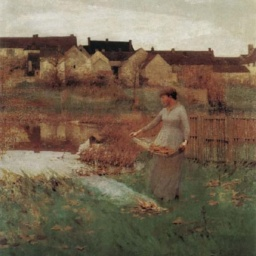

In [ ]:
Image.open(df.iloc[0]['full_path'])

**Image data is stored into dictionary, that is indexed based on the file path**

In [ ]:
images = dict()

In [ ]:
# 2 min is duration of reading
for idx, row in data.iterrows():
  images[(row['full_path'])] = imageio.imread(row['full_path'])

/tmp/ipython-input-1367763607.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images[(row['full_path'])] = imageio.imread(row['full_path'])


**test that numpy data was read correctly**

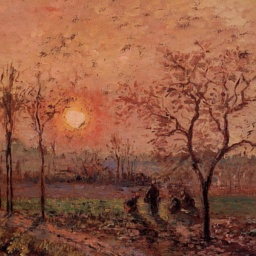

In [ ]:
Image.fromarray(images[data.iloc[4550]['full_path']])

# Image content EDA

In [ ]:
from enum import Enum

class Color(Enum):
    RED = "R"
    GREEN = "G"
    BLUE = "B"

R = Color.RED.value
G = Color.GREEN.value
B = Color.BLUE.value

In [ ]:
def calculate_channel_average(img, channel):
    """
    Calculate channel average.
    Remark: Only used for plotting
    """
    channel_dict = {R: 0, G: 1, B: 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in img]).flatten()
    return np.mean(channel_intensities)

In [ ]:
def create_average_values_data_frame(df, color_enum):
    df_averages = df.groupby("label").agg(average_color=('full_path', lambda s:  np.mean([calculate_channel_average(images[x], channel=color_enum.value) for x in s ]) ) )
    df_averages['color_name'] = color_enum.name.lower()
    df_averages = df_averages.reindex(genres_sorted_era).reset_index()
    return df_averages

In [ ]:
red_channel_average = create_average_values_data_frame(data, Color.RED)
red_channel_average

,label,average_color,color_name
0,renaissance,120.399083,red
1,baroque,98.903448,red
2,ukiyo_e,161.021236,red
3,romanticism,126.165804,red
4,realism,122.907473,red
5,impressionism,136.587255,red
6,post_impressionism,135.037164,red
7,art_nouveau,154.085876,red
8,expressionism,135.798163,red
9,surrealism,125.492452,red


In [ ]:
green_channel_average = create_average_values_data_frame(data, Color.GREEN)
green_channel_average

,label,average_color,color_name
0,renaissance,102.549813,green
1,baroque,83.422483,green
2,ukiyo_e,148.460306,green
3,romanticism,111.616305,green
4,realism,111.301176,green
5,impressionism,124.873346,green
6,post_impressionism,123.502479,green
7,art_nouveau,139.976706,green
8,expressionism,122.644778,green
9,surrealism,115.815025,green


In [ ]:
blue_channel_average = create_average_values_data_frame(data, Color.BLUE)
blue_channel_average

,label,average_color,color_name
0,renaissance,87.372964,blue
1,baroque,68.121964,blue
2,ukiyo_e,127.852791,blue
3,romanticism,92.933287,blue
4,realism,94.636847,blue
5,impressionism,105.857414,blue
6,post_impressionism,104.864517,blue
7,art_nouveau,122.124193,blue
8,expressionism,106.975204,blue
9,surrealism,102.817421,blue


In [ ]:
def plot_channel_intensity_barplot(df, channel):
    """
    Plot a individual bar plot with specified channel
    """
    title_dict = {R: "red", G: "green", B: "blue"}
    palet_dict = {R: "Reds_d", G: "Greens_d", B: "Blues_d"}
    plt.figure(figsize=(10,3))

    values = df["average_color"].values
    pal = sns.color_palette(palet_dict[channel], len(values))
    rank = values.argsort().argsort()
    x =[label for label in df["label"]]
    ax = sns.barplot(x=x, y=values, hue=x, palette=list(np.array(pal[::-1])[rank]))

    plt.ylabel("Intensity")
    plt.title(f"Average {title_dict[channel]} channel intensity for genres")

    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=55)

**Display average color intensities based on genres**

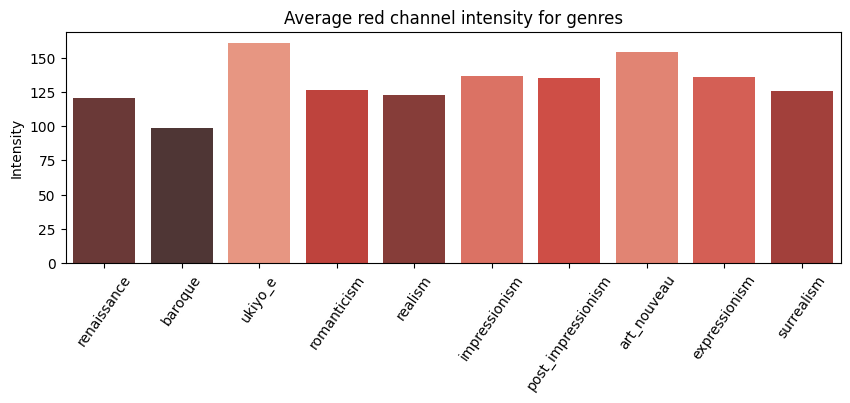

In [ ]:
plot_channel_intensity_barplot(red_channel_average, R)

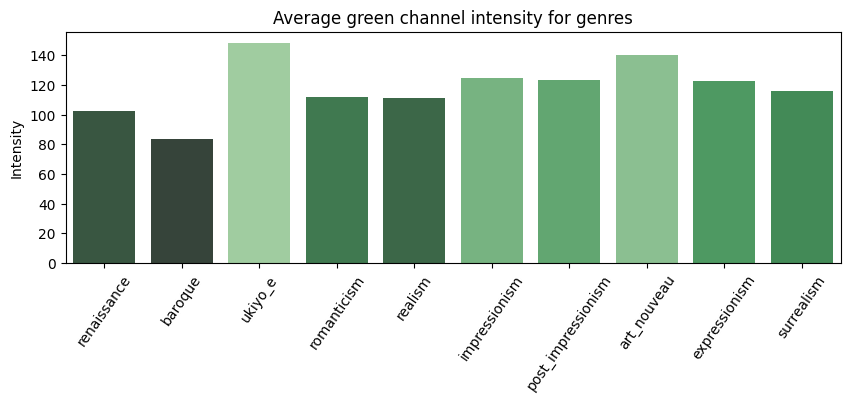

In [ ]:
plot_channel_intensity_barplot(green_channel_average, G)

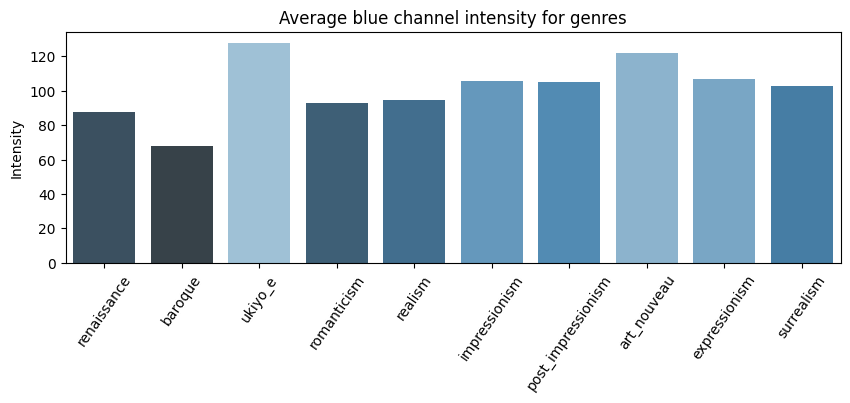

In [ ]:
plot_channel_intensity_barplot(blue_channel_average, B)

In [ ]:
channel_averages = pd.concat([red_channel_average, green_channel_average, blue_channel_average])
channel_averages

,label,average_color,color_name
0,renaissance,120.399083,red
1,baroque,98.903448,red
2,ukiyo_e,161.021236,red
3,romanticism,126.165804,red
4,realism,122.907473,red
5,impressionism,136.587255,red
6,post_impressionism,135.037164,red
7,art_nouveau,154.085876,red
8,expressionism,135.798163,red
9,surrealism,125.492452,red


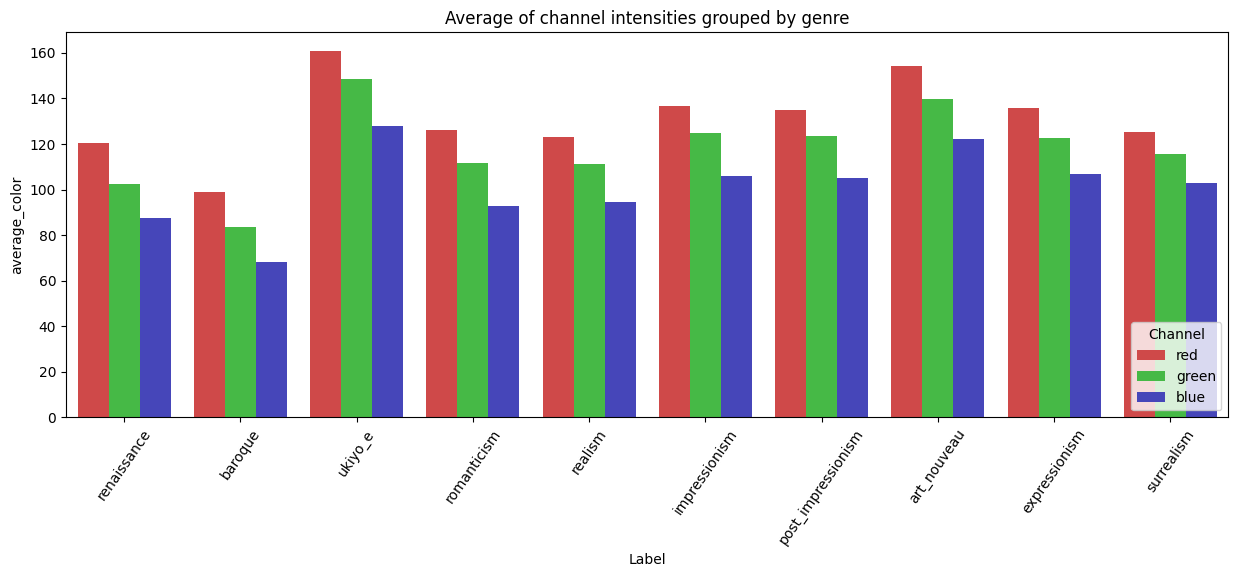

In [ ]:
plt.figure(figsize=(15,5))

colors = [[0.9, 0.2, 0.2], [0.2, 0.8, 0.2], [0.2, 0.2, 0.8] ]

ax = sns.barplot(x=channel_averages["label"], y="average_color", hue="color_name", data=channel_averages, palette=colors)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=55);

plt.xlabel("Label")
plt.title("Average of channel intensities grouped by genre")
ax.legend(title="Channel",loc="lower right")

In [ ]:
# @title
display_section(FINDINGS_SECTION)

## Findings 01 ##

  

References:
1.   https://www.quora.com/Why-are-so-many-old-paintings-so-dark-looking
2.   https://www.artelino.com/articles/ukiyo-e.asp
3.   https://www.thecollector.com/many-faces-art-nouveaus-themes-and-influences/

Certain genres, like Baroque and Renaissance are darker on average, while other like Ukiyo-e and Art Nouveau seems to brighter on average.

Reasons for darker average:
- Aging of images, since these are the oldest genres.
- Techniques like Chiaroscuro and tenebrism, where  dramatic contrasts of light and shadow were used to create depth and emotional intensity.
This naturally results in darker average tones.

Reasons for brighter average:
- Different medium:
  Woodblock printing (Ukiyo-e) and lithography (Art Nouveau posters) naturally lend themselves to brighter, more uniform color application than oil painting.
- Many Ukiyo-e prints feature light or white backgrounds.
- Usage of brighter colors on average in genres.


In [ ]:
display_section(FINDINGS_SECTION)

## Findings 02 ##

  

**Across all genres there is consistency that red mean is larger than green mean, which is larger than blue mean**

In [ ]:
color_differences = pd.DataFrame()
color_differences['label'] = red_channel_average['label']

color_differences['red_minus_green'] = red_channel_average['average_color'] - green_channel_average['average_color']
color_differences['green_minus_blue'] = green_channel_average['average_color'] - blue_channel_average['average_color']

color_differences

,label,red_minus_green,green_minus_blue
0,renaissance,17.849270,15.176849
1,baroque,15.480965,15.300520
2,ukiyo_e,12.560930,20.607515
3,romanticism,14.549499,18.683017
4,realism,11.606297,16.664329
5,impressionism,11.713909,19.015932
6,post_impressionism,11.534685,18.637962
7,art_nouveau,14.109170,17.852512
8,expressionism,13.153385,15.669574
9,surrealism,9.677427,12.997603


While this is the case, specific reasons for this could vary. Some of possible reasons suggested from Copilot:

- Red pigments like vermilion, cinnabar, and ochre were widely available and stable across centuries, while Blue pigments (like ultramarine from lapis lazuli) were rare and expensive until synthetic versions emerged in the 19th century.
- Human skin and warm light present in paintings add bias to red.
- Canvas and Paper on which artworks are created are usualy whie, so they would add to red bias.
- Digitization and Imaging Bias. Camera sensors and scanning processes used in digitization, may slightly favor red tones due to white balance settings or lighting conditions.

Since this bias is present across all genres, it would make sense to inspect images, that deviate from this norm, to find the reasons.